In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geojson
from geopy.distance import vincenty
import shapefile as shp
import math
import requests
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, box
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get ACLED Conflict Data

In [2]:
acled_historical_url = "https://www.acleddata.com/wp-content/uploads/2017/01/ACLED-Version-7-All-Africa-1997-2016_csv_dyadic-file.zip"
acled_realtime_url = "https://www.acleddata.com/wp-content/uploads/2017/12/ACLED-All-Africa-File_20170101-to-20171202_csv.zip"

In [3]:
def get_acled_data(url):
    
    df = pd.read_csv(url, encoding='latin1')
    
    # Drop extra unnamed columns
    for col in df.columns:
        if 'Unnamed:' in col:
            del df[col]
            
    # Convert EVENT_DATE to datetime
    df['EVENT_DATE'] = df['EVENT_DATE'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
    
    # Convert LATITUDE AND LONGITUDE to floats
    df['LATITUDE'] = df['LATITUDE'].apply(float)
    df['LONGITUDE'] = df['LONGITUDE'].apply(float)
    
    # Set index equal to event date
    df.index = df['EVENT_DATE']
    del df.index.name
    
    return df

In [4]:
acled_historical = get_acled_data(acled_historical_url)

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
acled_realtime = get_acled_data(acled_realtime_url)

In [6]:
def combine_historical_and_realtime(hist, real):
    df = pd.concat([acled_historical, acled_realtime])
    df = df.sort_values(by=['EVENT_DATE'])
    return df

In [7]:
acled = combine_historical_and_realtime(acled_historical, acled_realtime)

In [8]:
acled.head()

,GWNO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ALLY_ACTOR_1,INTER1,...,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,NOTES,FATALITIES
1997-01-01,451,1SIE,76306.0,1997-01-01,1997,3,Headquarters or base established,Military Forces of Sierra Leone (1997-1998),NaN,1,...,Southern,Moyamba,Kori,Taiama,8.20359,-12.06021,2,NPWJ p.469,base,0
1997-01-01,482,1CEN,15623.0,1997-01-01,1997,1,Battle-No change of territory,Military Forces of Central African Republic (1...,Mutiny of Military Forces of Central African R...,1,...,Bangui,Bangui,Bangui,Bangui,4.36197,18.58664,1,BBC Monitoring,"4 deaths reported, denied by both sides, anti-...",4
1997-01-01,451,9SIE,76314.0,1997-01-01,1997,3,Strategic development,Kamajor Militia,NaN,3,...,Southern,Bo,Valunia,Valunia,8.31715,-11.73357,2,NPWJ p.405,looting/presense,0
1997-01-01,451,8SIE,76313.0,1997-01-01,1997,3,Strategic development,Kamajor Militia,NaN,3,...,Southern,Bonthe,Nongoba Bullom,Badjia,7.43380,-12.24188,2,NPWJ p.405,looting/presense,0
1997-01-01,451,7SIE,76312.0,1997-01-01,1997,3,Strategic development,RUF: Revolutionary United Front,NaN,2,...,Northern,Tonkolili,Kholifa Rowalla,Magburaka,8.71667,-11.95000,3,NPWJ p.231,looting/presense,0


# Conflict in South Sudan

Process ACLED data on south sudan.

In [9]:
def process_south_sudan_data(df):
    
    # Select only conflicts in south sudan
    df = df[df['COUNTRY'] == 'South Sudan']
    
    # Select only the columns we need
    df = df[['EVENT_DATE', 'YEAR', 'EVENT_TYPE', 'ACTOR1',
            'INTER1', 'ACTOR2', 'INTER2', 'INTERACTION', 'LOCATION', 
             'LATITUDE', 'LONGITUDE', 'FATALITIES']]
    
    # 'EVENT_ID_NO_CNTY', 'ALLY_ACTOR_1', 'ALLY_ACTOR_2',
    
    # Add new date and time columns
    df['DAYOFMONTH'] = df['EVENT_DATE'].apply(lambda x: x.day)
    
    df['MONTH'] = df['EVENT_DATE'].apply(lambda x: x.month)
                                                         
    months = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

    df['Month'] = df['EVENT_DATE'].apply(lambda x: months[str(x.month).zfill(2)])
    
    days_of_week = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    df['Day'] = df['EVENT_DATE'].apply(lambda x: days_of_week[x.dayofweek])
    
    # Classify holidays
    """ 
    South Sudan Public Holidays 2017
    https://publicholidays.africa/south-sudan/
    
    1 Jan	Sun	New Year's Day
    2 Jan	Mon	New Year Holiday
    10 Mar	Fri	National Prayer Day
    14 Apr	Fri	Good Friday
    15 Apr	Sat	Easter Saturday
    16 Apr	Sun	Easter Sunday
    17 Apr	Mon	Easter Monday
    1 May	Mon	Labour Day
    16 May	Tue	SPLA Day
    25 Jun	Sun	Eid al-Fitr
    9 Jul	Sun	Independence Day
    30 Jul	Sun	Martyrs' Day
    1 Sep	Fri	Eid al-Adha
    24 Dec	Sun	Christmas Eve
    25 Dec	Mon	Christmas Day
    26 Dec	Tue	Christmas Holiday
    """
    
    # Make it a geodataframe
    geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
    df = df.drop(['LONGITUDE', 'LATITUDE'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf

In [10]:
south_sudan = process_south_sudan_data(acled)

In [11]:
south_sudan.head(2)

,EVENT_DATE,YEAR,EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION,FATALITIES,DAYOFMONTH,MONTH,Month,Day,geometry
2011-07-14,2011-07-14,2011,Violence against civilians,LRA: Lords Resistance Army,2,Civilians (South Sudan),7,27,Deim Zubeir,0,14,7,Jul,Thursday,POINT (26.21618 7.71788)
2011-07-15,2011-07-15,2011,Battle-No change of territory,George Athor Deng Rebel Group,2,Murle Ethnic Militia (South Sudan),4,24,Pibor,0,15,7,Jul,Friday,POINT (33.12967 6.79433)


# Total number of conflicts per day

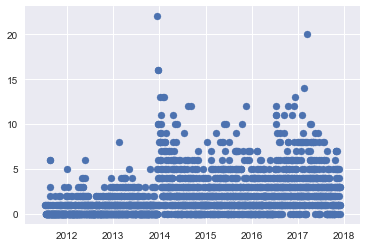

In [12]:
num_conflicts_per_day = south_sudan.resample('D').count()['EVENT_DATE']
plt.scatter(num_conflicts_per_day.index, num_conflicts_per_day);

# Average number of conflicts by day of week

In [13]:
days_of_week = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


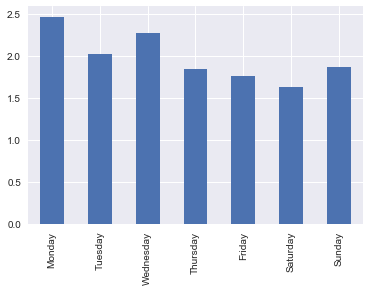

In [14]:
day_counts = pd.DataFrame(pd.Series(south_sudan.resample('d').index).apply(lambda x: days_of_week[x.dayofweek]).value_counts())
total_by_day = pd.DataFrame(south_sudan['Day'].value_counts())

merged = pd.merge(total_by_day, day_counts, how='left', left_index= True , right_index= True)
avg_by_day = merged['Day'] / merged[0]
avg_by_day.loc[days_of_week].plot(kind='bar')

# Total number of conflicts per week

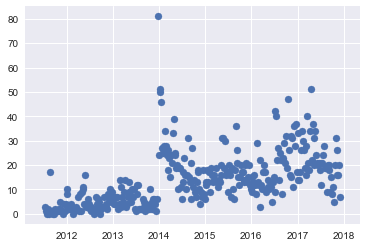

In [15]:
num_conflicts_by_week = south_sudan.resample('W').count()['EVENT_DATE']
plt.scatter(num_conflicts_by_week.index, num_conflicts_by_week);

# Total number of conflicts per month

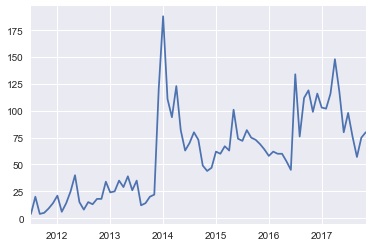

In [16]:
num_conflicts_by_month = south_sudan.resample('M').count()['EVENT_DATE']
num_conflicts_by_month.plot()

# Average number of conflicts by month

# Number of Conflicts by Year

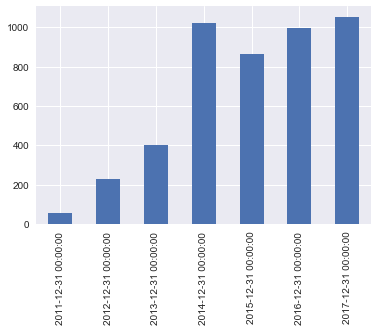

In [17]:
num_conflicts_by_year = south_sudan.resample('A').count()['EVENT_DATE']
num_conflicts_by_year.plot(kind='bar')

# Number of Conflicts by Actor

In [18]:
def count_conflicts_by_actor(df):
    
    conflicts_by_actor1 = pd.DataFrame(df.groupby(by='ACTOR1').count()['EVENT_DATE'])
    conflicts_by_actor2 = pd.DataFrame(df.groupby(by='ACTOR2').count()['EVENT_DATE'])
    
    total_conflicts_by_actor = pd.merge(conflicts_by_actor1, conflicts_by_actor2, how='outer',
                                       left_index=True, right_index=True).sum(axis=1)
    total_conflicts_by_actor = pd.DataFrame(total_conflicts_by_actor)
    total_conflicts_by_actor.columns = ['conflicts']
    total_conflicts_by_actor = total_conflicts_by_actor.sort_values(by='conflicts', ascending=False)
    
    return total_conflicts_by_actor

In [19]:
south_sudan_by_actor = count_conflicts_by_actor(south_sudan)

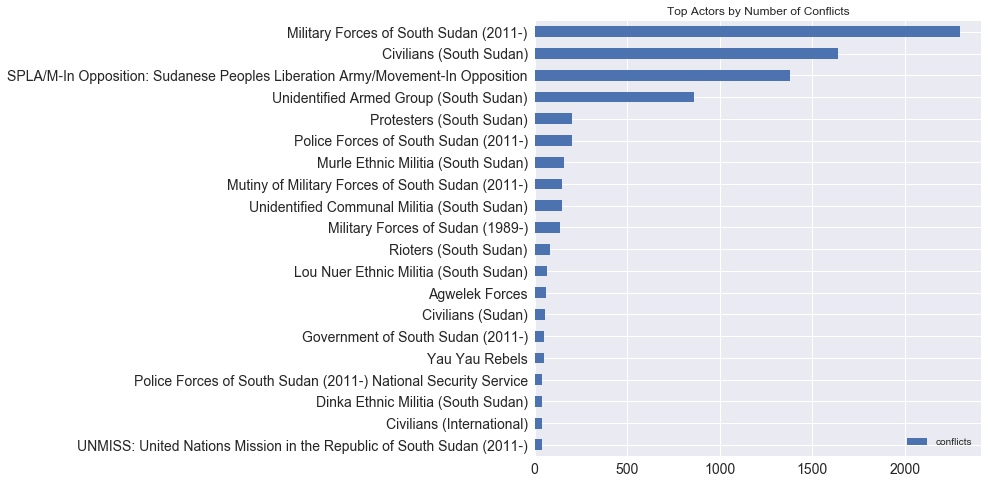

In [20]:
south_sudan_by_actor.head(20).plot(kind='barh', title='Top Actors by Number of Conflicts', fontsize=14,figsize=(8,8))
plt.gca().invert_yaxis()
plt.show()

# Number of Conflicts by Event Type

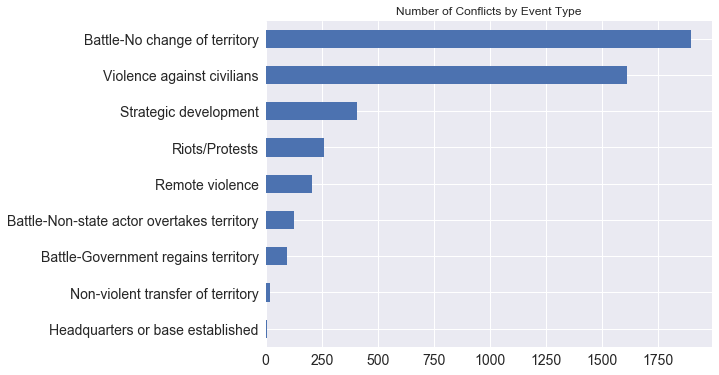

In [21]:
south_sudan['EVENT_TYPE'].value_counts().plot(kind='barh', figsize=(8,6), fontsize=14, 
                                              title='Number of Conflicts by Event Type')
plt.gca().invert_yaxis()

# Prepare Data for Spatial Temporal LSTMs

# Gridded South Sudan

In [22]:
import requests
import json

In [23]:
response = requests.get("https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

In [24]:
data = response.json()

In [25]:
country_polygon = [i for i in data['features'] if i['properties']['name'] == 'South Sudan'][0]

In [26]:
with open("../data/country_polygon.json", "w") as f:
    json.dump(country_polygon, f)

In [27]:
country_polygon = gpd.read_file("../data/country_polygon.json")

In [28]:
country_polygon.crs

{'init': u'epsg:4326'}

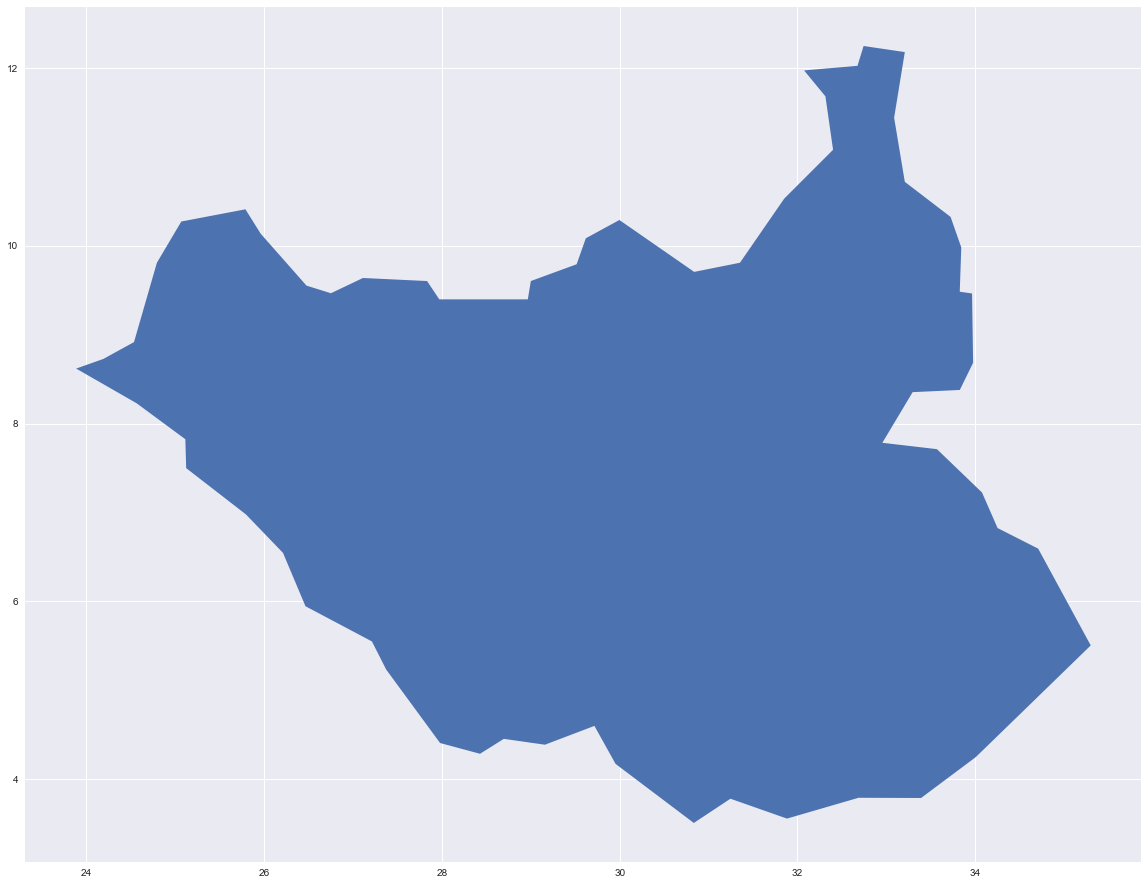

In [52]:
country_polygon.plot(figsize=(20,20))

In [31]:
min_lon = min(list(country_polygon['geometry'][0].exterior.coords.xy[0]))
max_lon = max(list(country_polygon['geometry'][0].exterior.coords.xy[0]))
min_lat = min(list(country_polygon['geometry'][0].exterior.coords.xy[1]))
max_lat = max(list(country_polygon['geometry'][0].exterior.coords.xy[1]))

In [32]:
import shapefile as shp
import math

# Create a grid with cells ~10km in width and height

In [33]:
def shapefile2grid(minx,maxx,miny,maxy, dx, dy, outputfile):
    nx = int(math.ceil(abs(maxx - minx)/dx))
    ny = int(math.ceil(abs(maxy - miny)/dy))

    w = shp.Writer(shp.POLYGON)
    w.autoBalance = 1
    w.field("ID")
    id=0

    for i in range(ny):
        for j in range(nx):
            id+=1
            vertices = []
            parts = []
            vertices.append([min(minx+dx*j,maxx),max(maxy-dy*i,miny)])
            vertices.append([min(minx+dx*(j+1),maxx),max(maxy-dy*i,miny)])
            vertices.append([min(minx+dx*(j+1),maxx),max(maxy-dy*(i+1),miny)])
            vertices.append([min(minx+dx*j,maxx),max(maxy-dy*(i+1),miny)])
            parts.append(vertices)
            w.poly(parts)
            w.record(id)

    w.save(outputfile)

In [34]:
minx, maxx, miny, maxy = min_lon,max_lon,min_lat,max_lat
dx, dy = 0.1, 0.1
shapefile2grid(minx, maxx, miny, maxy, dx, dy, "../data/test_grid.shp")

In [35]:
grid = gpd.read_file("../data/test_grid.shp")

In [66]:
grid.crs = {'init': '4326'}

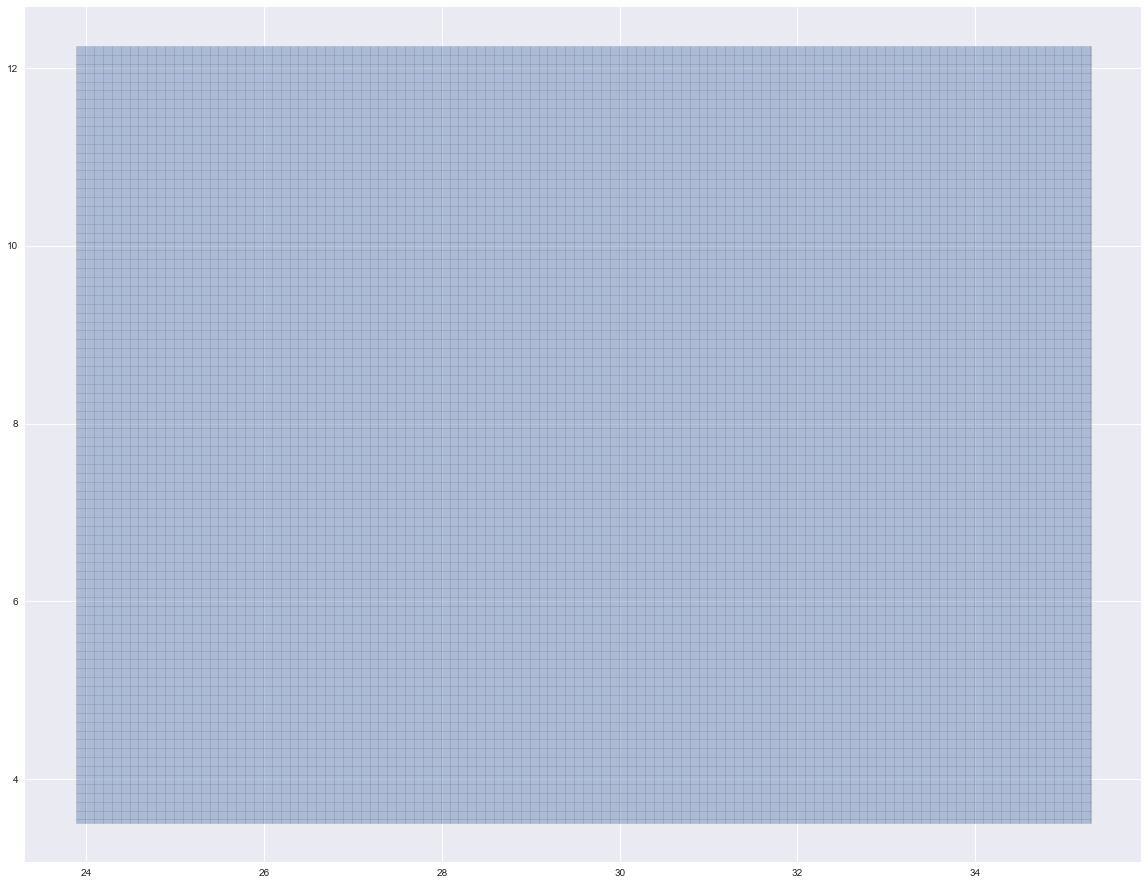

In [67]:
grid.plot(figsize=(20,20), alpha=0.4, linewidth=0.5, edgecolor='grey')

In [68]:
grid.head()

,ID,geometry
0,1,"POLYGON ((23.88698 12.248008, 23.98698 12.2480..."
1,2,"POLYGON ((23.98698 12.248008, 24.08698 12.2480..."
2,3,"POLYGON ((24.08698 12.248008, 24.18698 12.2480..."
3,4,"POLYGON ((24.18698 12.248008, 24.28698 12.2480..."
4,5,"POLYGON ((24.28698 12.248008, 24.38698 12.2480..."


# Intersect country boundary and grid

In [69]:
grid_intersection = gpd.overlay(country_polygon, grid, how='intersection')

In [65]:
grid_intersection.crs

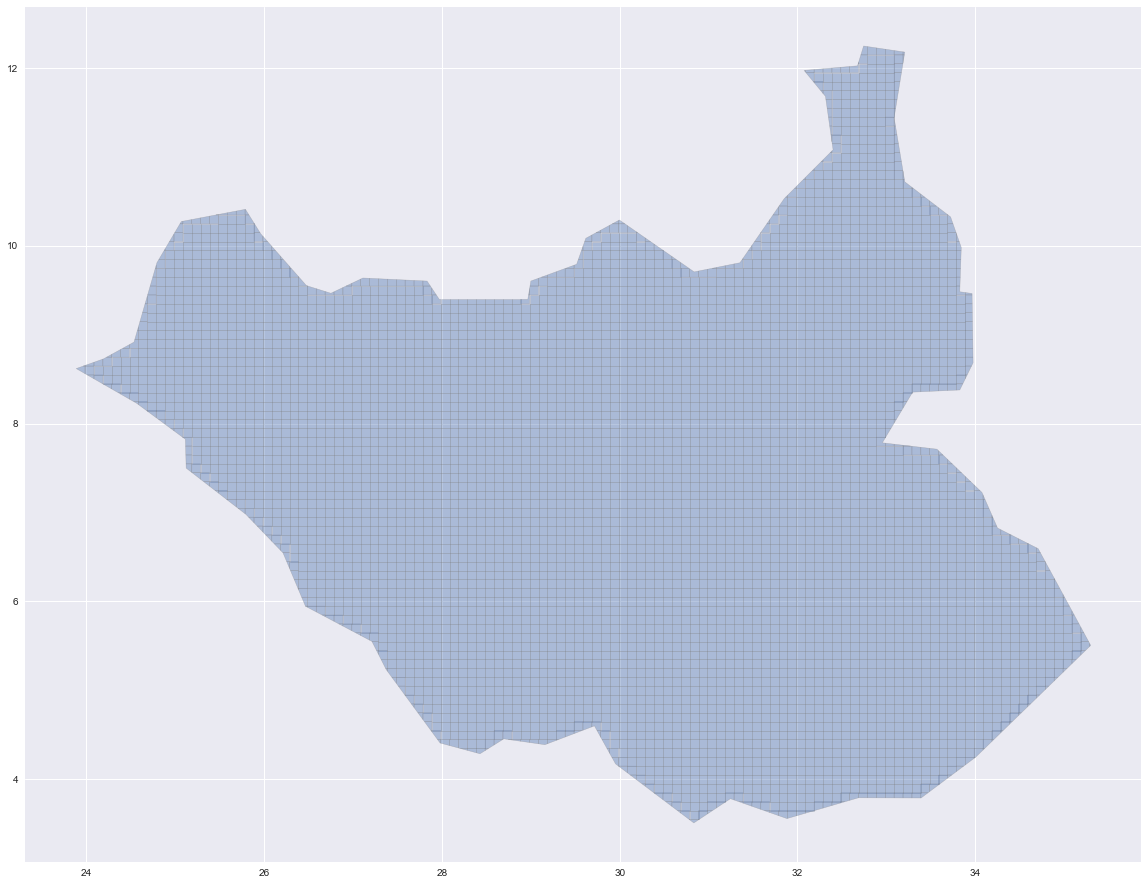

In [39]:
grid_intersection.plot(figsize=(20,20), alpha=0.4, linewidth=0.5, edgecolor='grey')

In [44]:
grid_intersection.head()

,id,name,ID,geometry
0,SSD,South Sudan,5152,"POLYGON ((32.98698 7.848008, 32.9918759736662 ..."
1,SSD,South Sudan,5037,"POLYGON ((32.9918759736662 7.848008, 32.98698 ..."
2,SSD,South Sudan,5151,"POLYGON ((32.88698 7.848008, 32.98698 7.848008..."
3,SSD,South Sudan,5036,"POLYGON ((32.98698 7.848008, 32.88698 7.848008..."
4,SSD,South Sudan,5150,"POLYGON ((32.78698 7.848008, 32.88698 7.848008..."


# Cells to Centroids

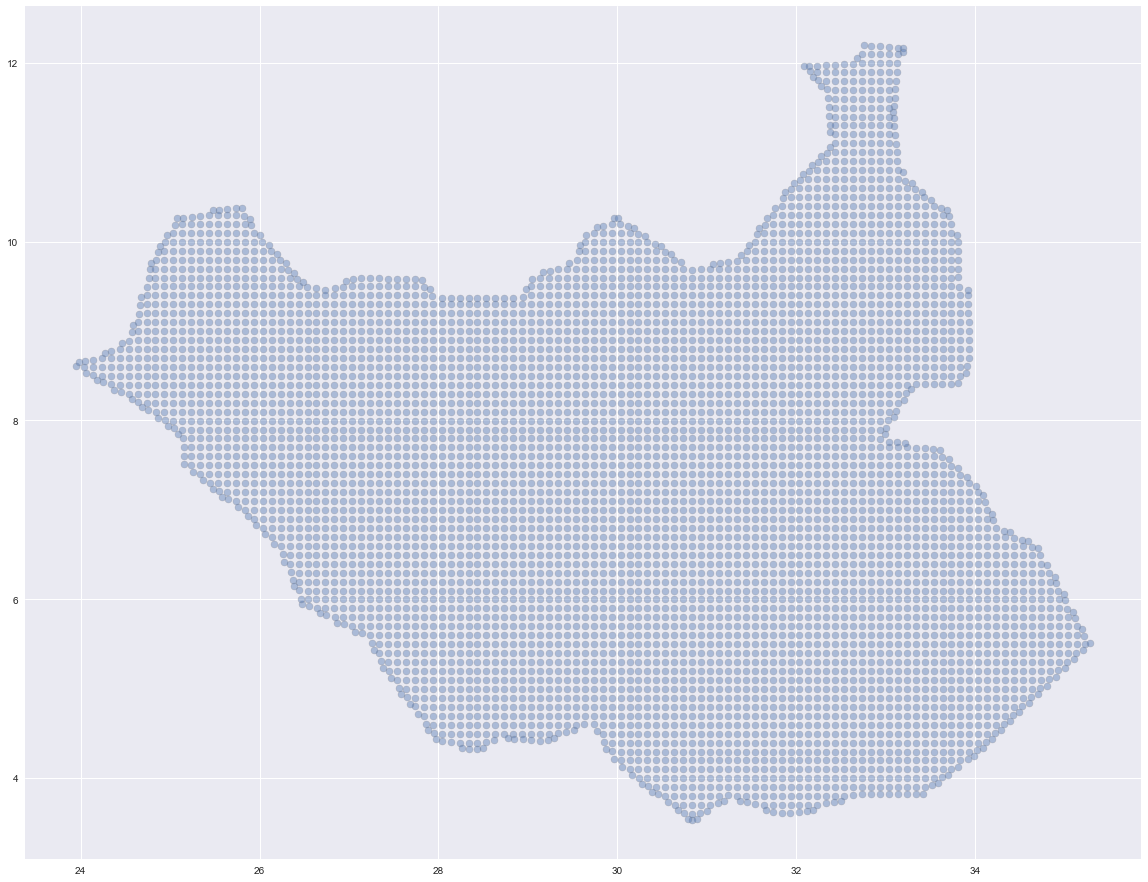

In [49]:
centroids = grid_intersection['geometry'].centroid
centroids.plot(figsize=(20,20), alpha=0.4, linewidth=0.5, edgecolor='grey')

# Centroid Buffers

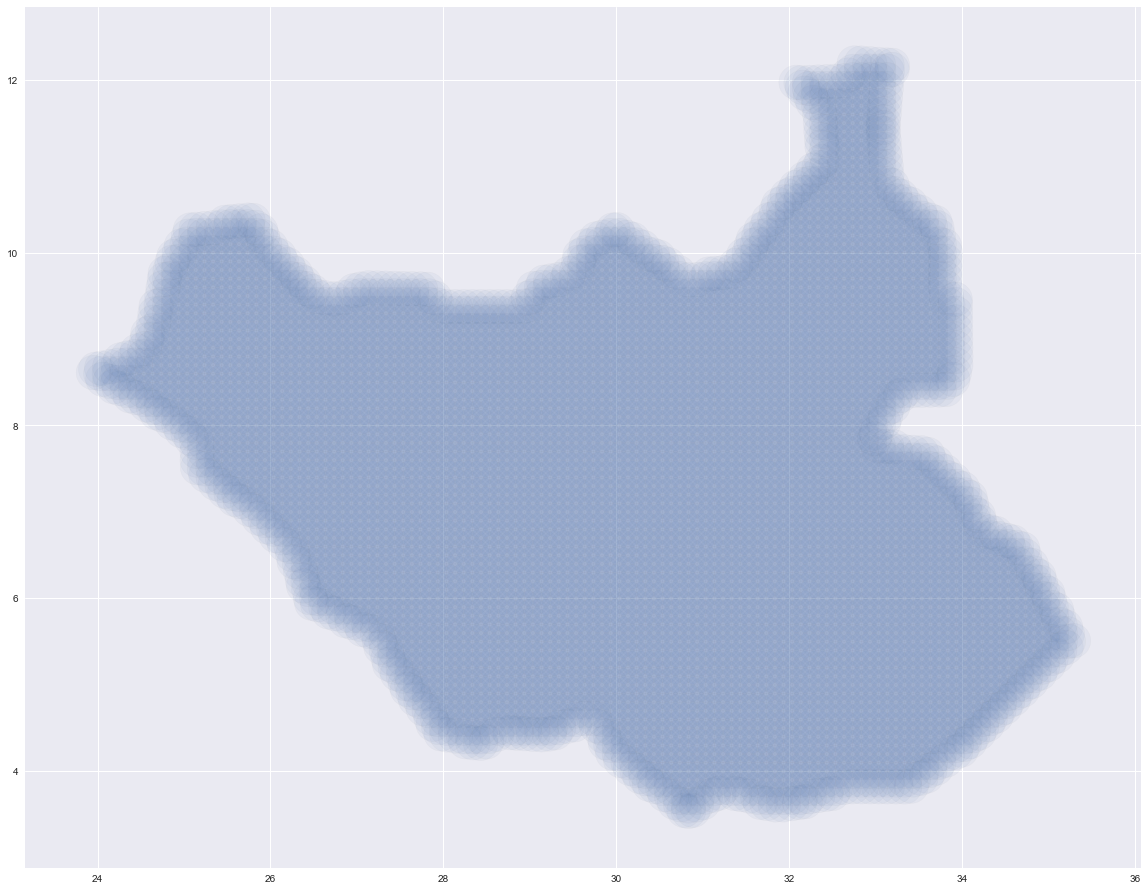

In [62]:
circles = centroids.buffer(0.2)
circles.plot(figsize=(20,20), alpha=0.05, linewidth=0.5, edgecolor='grey')

# Load in point layers

In [40]:
un_military = gpd.read_file("../data/un_military.geojson")
un_military.crs

{'init': u'epsg:3857'}

Conver to 4326

In [41]:
un_military = un_military.to_crs({'init': 'epsg:4326'})

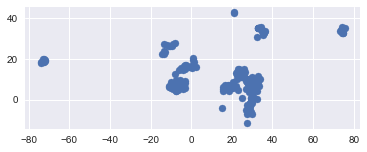

In [42]:
un_military.plot()

# Intersect points with grid polygon

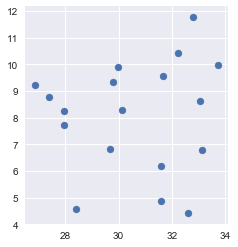

In [43]:
un_military[un_military.intersects(grid_intersection.unary_union)].plot()


# Calculate area of each cell in kilometers

https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

In [141]:
def calculate_cell_areas(gdf):
    
    # Now copy your GeoDataFrame and change the projection to a Cartesian system
    # (EPSG:3857, unit= m as in the answer of ResMar)
    
    gdf = gdf.copy()
    gdf.crs = {'init':'epsg:3857'}
    
    # Now the area in km/sqr
    gdf["area"] = gdf['geometry'].area/ 10**6
    
    # But the surfaces in the Mercator projection are not correct,
    # so with other projection in meters.
    
    gdf= gdf.to_crs({'init': 'epsg:32633'})
    gdf["area"] = gdf['geometry'].area/ 10**6

    return gdf

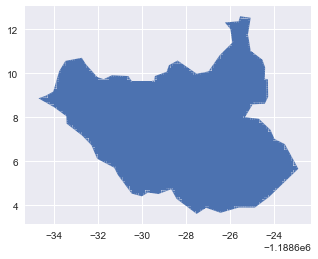

In [145]:
calculate_cell_areas(grid_intersection).plot()

In [118]:
grid_intersection['area'] = grid_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)

In [119]:
grid_intersection.head()

,id,name,ID,geometry,area
0,SSD,South Sudan,5152,"POLYGON ((-1188625.268051401 8.06917821439613,...",1.990850e-11
1,SSD,South Sudan,5037,POLYGON ((-1188625.262983523 8.069178212724477...,3.456244e-09
2,SSD,South Sudan,5151,POLYGON ((-1188625.371562513 8.069178248539568...,8.977205e-09
3,SSD,South Sudan,5036,"POLYGON ((-1188625.268051401 8.06917821439613,...",9.933056e-09
4,SSD,South Sudan,5150,POLYGON ((-1188625.475073627 8.069178282683009...,9.933056e-09


In [122]:
grid_intersection.loc[10]

id                                                        SSD
name                                              South Sudan
ID                                                       5148
geometry    POLYGON ((-1188625.682095855 8.069178350969896...
area                                              9.93306e-09
Name: 10, dtype: object

In [98]:
grid_intersection.loc[10]['geometry'].area

0.010000000000000106

In [102]:
grid_intersection.crs = {'init': 'epsg:3857'}

In [103]:
print grid_intersection.crs

{'init': 'epsg:3857'}


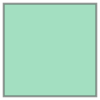

In [109]:
grid_intersection.loc[10]['geometry']

In [111]:
grid_intersection.loc[10]['geometry'].area / 10**6

1.0000000000000106e-08

But the surfaces in the Mercator projection are not correct, so with other projection in meters.

In [112]:
grid_intersection= grid_intersection.to_crs({'init': 'epsg:32633'})
grid_intersection["area"] = grid_intersection['geometry'].area/ 10**6
grid_intersection.head()

,id,name,ID,geometry,area
0,SSD,South Sudan,5152,"POLYGON ((-1188625.268051401 8.06917821439613,...",2.133106e-11
1,SSD,South Sudan,5037,POLYGON ((-1188625.262983523 8.069178212724477...,3.703211e-09
2,SSD,South Sudan,5151,POLYGON ((-1188625.371562513 8.069178248539568...,9.618672e-09
3,SSD,South Sudan,5036,"POLYGON ((-1188625.268051401 8.06917821439613,...",1.064282e-08
4,SSD,South Sudan,5150,POLYGON ((-1188625.475073627 8.069178282683009...,1.064282e-08


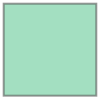

In [114]:
grid_intersection.loc[10]['geometry']

In [115]:
grid_intersection.loc[10]['geometry'].area

0.010642823485542205

In [178]:
import os, sys
import ogr
from math import ceil


def create_grid(outputGridfn,xmin,xmax,ymin,ymax,gridHeight,gridWidth):

    # convert sys.argv to float
    xmin = float(xmin)
    xmax = float(xmax)
    ymin = float(ymin)
    ymax = float(ymax)
    gridWidth = float(gridWidth)
    gridHeight = float(gridHeight)

    # get rows
    rows = ceil((ymax-ymin)/gridHeight)
    # get columns
    cols = ceil((xmax-xmin)/gridWidth)

    # start grid cell envelope
    ringXleftOrigin = xmin
    ringXrightOrigin = xmin + gridWidth
    ringYtopOrigin = ymax
    ringYbottomOrigin = ymax-gridHeight

    # create output file
    outDriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputGridfn):
        os.remove(outputGridfn)
    outDataSource = outDriver.CreateDataSource(outputGridfn)
    outLayer = outDataSource.CreateLayer(outputGridfn,geom_type=ogr.wkbPolygon )
    featureDefn = outLayer.GetLayerDefn()

    # create grid cells
    countcols = 0
    while countcols < cols:
        countcols += 1

        # reset envelope for rows
        ringYtop = ringYtopOrigin
        ringYbottom =ringYbottomOrigin
        countrows = 0

        while countrows < rows:
            countrows += 1
            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)

            # add new geom to layer
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(poly)
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy

            # new envelope for next poly
            ringYtop = ringYtop - gridHeight
            ringYbottom = ringYbottom - gridHeight

        # new envelope for next poly
        ringXleftOrigin = ringXleftOrigin + gridWidth
        ringXrightOrigin = ringXrightOrigin + gridWidth

    # Close DataSources
    outDataSource.Destroy()

ImportError: dlopen(/anaconda/lib/python2.7/site-packages/osgeo/_gdal.so, 2): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /anaconda/lib/libgdal.20.dylib
  Reason: image not found

In [115]:
from geojson import Feature, Point, Polygon, FeatureCollection

In [116]:
my_feature = Feature(geometry=Polygon(country_polygon['geometry']['coordinates'][0]),
                     properties={"country": "South Sudan"})

In [122]:
collection = FeatureCollection([my_feature])

In [124]:
collection

{"features": [{"geometry": {"coordinates": [[33.963393, 9.464285], [33.97498, 8.68456], [33.8255, 8.37916], [33.2948, 8.35458], [32.95418, 7.78497], [33.56829, 7.71334], [34.0751, 7.22595], [34.25032, 6.82607], [34.70702, 6.59422], [35.298007, 5.506], [34.620196, 4.847123], [34.005, 4.249885], [33.39, 3.79], [32.68642, 3.79232], [31.88145, 3.55827], [31.24556, 3.7819], [30.83385, 3.50917], [29.95349, 4.1737], [29.715995, 4.600805], [29.159078, 4.389267], [28.696678, 4.455077], [28.428994, 4.287155], [27.979977, 4.408413], [27.374226, 5.233944], [27.213409, 5.550953], [26.465909, 5.946717], [26.213418, 6.546603], [25.796648, 6.979316], [25.124131, 7.500085], [25.114932, 7.825104], [24.567369, 8.229188], [23.88698, 8.61973], [24.194068, 8.728696], [24.537415, 8.917538], [24.794926, 9.810241], [25.069604, 10.27376], [25.790633, 10.411099], [25.962307, 10.136421], [26.477328, 9.55273], [26.752006, 9.466893], [27.112521, 9.638567], [27.833551, 9.604232], [27.97089, 9.398224], [28.966597, 9.

In [123]:
gpd.GeoDataFrame.from_features(collection['features'])

TypeError: object of type 'float' has no len()

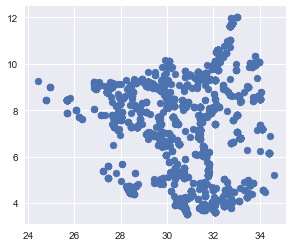

In [87]:
south_sudan.plot()

In [86]:
south_sudan['latitude']south_sudan.geometry.apply(lambda x: x.coords)

2011-07-14    ((26.21618, 7.71788))
2011-07-15    ((33.12967, 6.79433))
2011-07-16    ((26.06809, 8.01619))
2011-07-23          ((31.43, 7.63))
2011-08-03    ((31.61782, 4.86086))
2011-08-04    ((31.61782, 4.86086))
2011-08-18    ((32.02717, 8.04483))
2011-08-18    ((32.02717, 8.04483))
2011-08-18    ((32.02717, 8.04483))
2011-08-19    ((32.18881, 10.5988))
2011-08-19    ((32.02717, 8.04483))
2011-08-19    ((32.02717, 8.04483))
2011-08-19          ((27.12, 9.07))
2011-08-19    ((32.18881, 10.5988))
2011-08-19          ((27.12, 9.07))
2011-08-20    ((32.07455, 9.30455))
2011-08-20    ((32.07455, 9.30455))
2011-08-20    ((32.02717, 8.04483))
2011-08-20    ((32.07455, 9.30455))
2011-08-20    ((32.18881, 10.5988))
2011-08-20    ((32.02717, 8.04483))
2011-08-21          ((30.73, 8.09))
2011-08-21    ((29.78826, 9.25252))
2011-08-23    ((32.18881, 10.5988))
2011-09-04    ((25.68095, 8.46239))
2011-09-09    ((25.68095, 8.46239))
2011-09-26          ((31.67, 9.26))
2011-09-26          ((31.67,

# Define Target Variable

Our target variable $y$ is number of conflicts in South Sudan per day.

In [42]:
y = num_conflicts_per_day

Reshape y to a numpy array.

In [43]:
y = np.array(y).reshape(len(y),)

In [44]:
y.shape

(2332,)

# Define Features

In [59]:
month = pd.get_dummies(south_sudan[['Month']]).resample('d').sum().fillna(0)
month = np.array(month).reshape(month.shape[0], month.shape[1])

In [60]:
day = pd.get_dummies(south_sudan['Day']).resample('d').sum().fillna(0)
day = np.array(day).reshape(day.shape[0], day.shape[1])

In [61]:
features = [month, day]

In [62]:
X = np.hstack(features)

In [63]:
X.shape

(2332, 19)

# Split data into training and testing

In [64]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Split based on time
num_train_rows = 2000

X_train = X[:num_train_rows,:]
X_test = X[num_train_rows:,:]
y_train = y[:num_train_rows]
y_test = y[num_train_rows:]

# K Neighbors Regression

In [65]:
# Utilities
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsRegressor

In [66]:
n_neighbors=3
reg = KNeighborsRegressor(n_neighbors)

In [67]:
reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [68]:
print "Test set R^2: {:.2f}".format(reg.score(X_test, y_test))

Test set R^2: 0.71


In [69]:
pred = reg.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

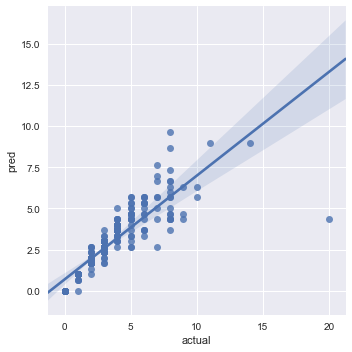

In [70]:
sns.lmplot('actual', 'pred', results);

# Linear Regression (OLS)

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [73]:
print "Test set R^2: {:.2f}".format(linear_reg.score(X_test, y_test))

Test set R^2: 1.00


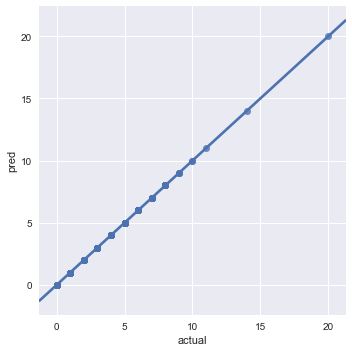

In [74]:
pred = linear_reg.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

# Ridge Regression

In [75]:
from sklearn.linear_model import Ridge

In [464]:
ridge = Ridge().fit(X_train, y_train)

In [465]:
print "Test set R^2: {:.2f}".format(ridge.score(X_test, y_test))

Test set R^2: 1.00


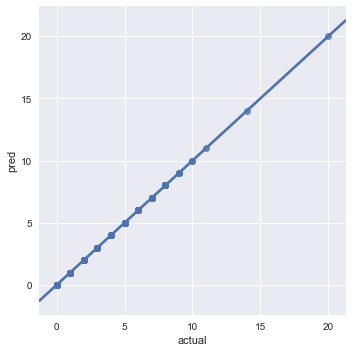

In [466]:
pred = ridge.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

# Lasso Linear Regression

In [467]:
from sklearn.linear_model import Lasso

In [468]:
lasso = Lasso().fit(X_train, y_train)

In [469]:
print "Test set R^2: {:.2f}".format(lasso.score(X_test, y_test))

Test set R^2: -0.26


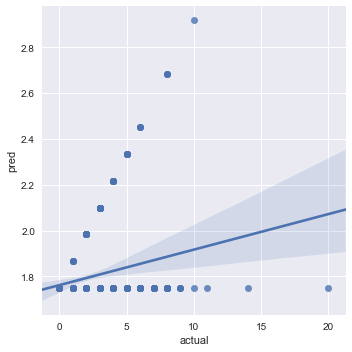

In [470]:
pred = lasso.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

# Decision Tree Regressor

In [471]:
from sklearn.tree import DecisionTreeRegressor

In [472]:
decision_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [473]:
print "Test set R^2: {:.2f}".format(decision_tree.score(X_test, y_test))

Test set R^2: 0.96


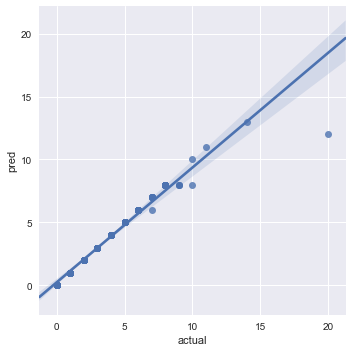

In [474]:
pred = decision_tree.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

# Random Forest Regressor

In [475]:
from sklearn.ensemble import RandomForestRegressor

In [476]:
random_forest = RandomForestRegressor().fit(X_train, y_train)

In [477]:
print "Test set R^2: {:.2f}".format(random_forest.score(X_test, y_test))

Test set R^2: 0.96


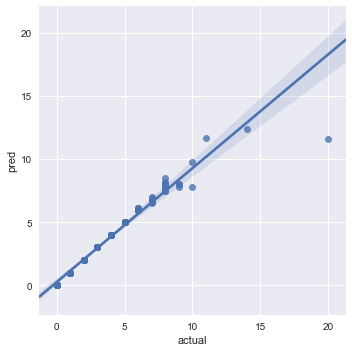

In [478]:
pred = random_forest.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

# Gradient Boosting Regressor

In [479]:
from sklearn.ensemble import GradientBoostingRegressor

In [480]:
gradient_boost = GradientBoostingRegressor().fit(X_train, y_train)

In [481]:
print "Test set R^2: {:.2f}".format(gradient_boost.score(X_test, y_test))

Test set R^2: 0.95


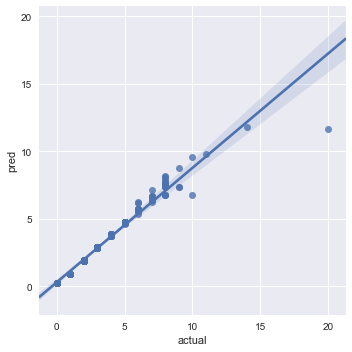

In [482]:
pred = gradient_boost.predict(X_test)

results = pd.DataFrame()
results['actual'] = y_test
results['pred'] = pred

sns.lmplot('actual', 'pred', results);

In [ ]:
plt.semilogy(a)

In [373]:
print "Test set R^2: {:.2f}".format(linear_reg.score(X_test, y_test))

Test set R^2: 1.00


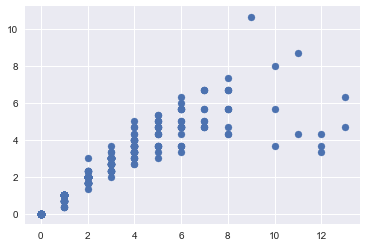

In [360]:
plt.scatter(x=results['actual'], y=results['pred'])

TypeError: scatter() takes at least 2 arguments (1 given)

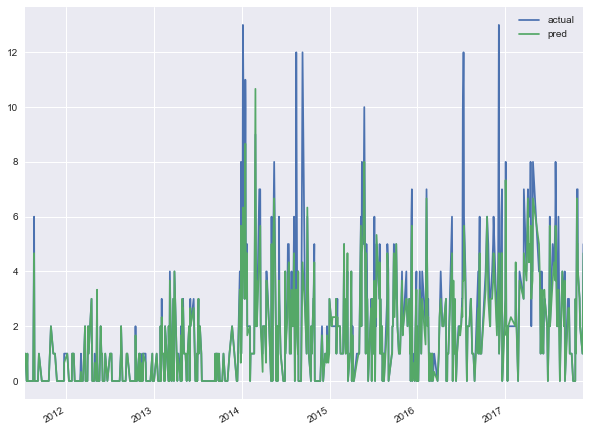

In [355]:
plt.scatter(results.plot(figsize=(10,8)))

ValueError: query data dimension must match training data dimension

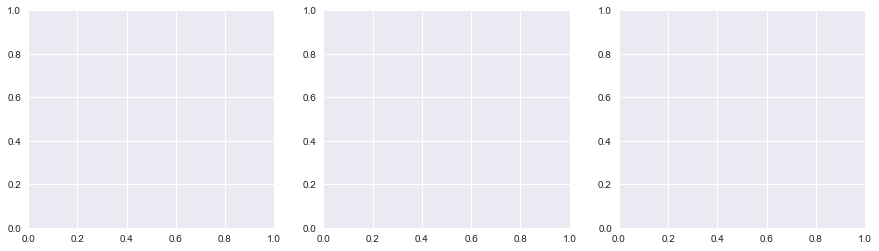

In [328]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

line = np.linspace(-3,3,1000).reshape(-1,1)

for n_neightbors, ax in zip([1,3,9], axes):

    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglear.cm2(1), markersize=8)
    
    ax.set_title(
        "{} neighbors \n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train), reg.score(X_test, y_test)
        )
    )
    
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
    

In [24]:
south_sudan.resample('d').count()

,EVENT_DATE,YEAR,EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION,FATALITIES,DAYOFMONTH,MONTH,Month,Day,geometry
2011-07-14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2011-07-15,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2011-07-16,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2011-07-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# Prepare data for machine learning

In [852]:
def prepare_data_for_model(df):
    
    df = df[['EVENT_DATE','DAYOFMONTH', 'Month', 'Day', 'YEAR', 'EVENT_TYPE']]
    
    # One hot encoding
    DAYOFMONTH = pd.get_dummies(df['DAYOFMONTH'])
    Month = pd.get_dummies(df['Month'])
    Day = pd.get_dummies(df['Day'])
    YEAR = pd.get_dummies(df['YEAR'])
    #EVENT_TYPE = pd.get_dummies(df['EVENT_TYPE'])
    
    dummies = pd.concat([DAYOFMONTH, Month, Day, YEAR], axis=1) #EVENT_TYPE

    dummies = dummies.resample('d').sum()
    
    num_conflicts = pd.DataFrame(df.resample('d')['YEAR'].count())
    num_conflicts.columns = ['Conflicts']
    
    output = pd.concat([dummies, num_conflicts], axis=1)
    
    # Replace NaNs with zeros
    output = output.fillna(0)
    
    return output

In [853]:
data = prepare_data_for_model(south_sudan)

In [854]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [855]:
data.shape

(2332, 58)

In [856]:
X = data.ix[:, data.columns != 'Conflicts']
y = data.ix[:, data.columns == 'Conflicts']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Split into training and testing data.

In [857]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 100)

In [858]:
clf_gini = DecisionTreeRegressor(random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=100,
           splitter='best')

In [859]:
y_pred = clf_gini.predict(X_test)

In [860]:
clf_gini.score(X_test, y_test)

0.46245516950873955

In [848]:
feature_importances = clf_gini.feature_importances_

In [849]:
feature_importances.shape

(57,)

In [850]:
importances = pd.DataFrame()
importances['feature'] = X.columns
importances['importance'] = feature_importances

In [851]:
importances

,feature,importance
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
5,6,0.000000
6,7,0.000000
7,8,0.000000
8,9,0.000000
9,10,0.000000


In [815]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
            max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [818]:
y_pred = clf_entropy.predict(X_test)
clf_entropy.score(X_test, y_test)

0.56857142857142862

In [820]:
feature_importances = clf_entropy.feature_importances_
importances = pd.DataFrame()
importances['feature'] = X.columns
importances['importance'] = feature_importances

In [821]:
importances

,feature,importance
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
5,6,0.000000
6,7,0.000000
7,8,0.000000
8,9,0.000000
9,10,0.000000


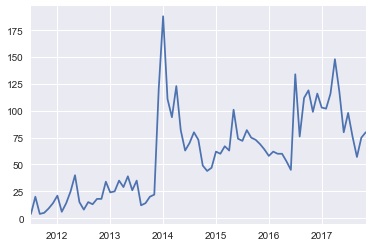

In [752]:
data.resample('m')['Conflicts'].sum().plot()

In [698]:
south_sudan[['DAYOFMONTH', 'MONTH', 'Day', 'EVENT_TYPE']]

,DAYOFMONTH,MONTH,Day,EVENT_TYPE
2011-07-14,14,7,Thursday,Violence against civilians
2011-07-15,15,7,Friday,Battle-No change of territory
2011-07-16,16,7,Saturday,Violence against civilians
2011-07-23,23,7,Saturday,Battle-No change of territory
2011-08-03,3,8,Wednesday,Strategic development
2011-08-04,4,8,Thursday,Strategic development
2011-08-18,18,8,Thursday,Violence against civilians
2011-08-18,18,8,Thursday,Violence against civilians
2011-08-18,18,8,Thursday,Battle-No change of territory
2011-08-19,19,8,Friday,Violence against civilians


In [685]:
data

,EVENT_DATE,YEAR,EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION,FATALITIES,...,geometry,Battle-Government regains territory,Battle-No change of territory,Battle-Non-state actor overtakes territory,Headquarters or base established,Non-violent transfer of territory,Remote violence,Riots/Protests,Strategic development,Violence against civilians
2011-07-14,2011-07-14,2011,Violence against civilians,LRA: Lords Resistance Army,2,Civilians (South Sudan),7,27,Deim Zubeir,0,...,POINT (26.21618 7.71788),0,0,0,0,0,0,0,0,1
2011-07-15,2011-07-15,2011,Battle-No change of territory,George Athor Deng Rebel Group,2,Murle Ethnic Militia (South Sudan),4,24,Pibor,0,...,POINT (33.12967 6.79433),0,1,0,0,0,0,0,0,0
2011-07-16,2011-07-16,2011,Violence against civilians,LRA: Lords Resistance Army,2,Civilians (South Sudan),7,27,Sopo,0,...,POINT (26.06809 8.01619),0,0,0,0,0,0,0,0,1
2011-07-23,2011-07-23,2011,Battle-No change of territory,Gatluak Gai Rebel Group,2,Military Forces of South Sudan (2011-),1,12,Koich,1,...,POINT (31.43 7.63),0,1,0,0,0,0,0,0,0
2011-08-03,2011-08-03,2011,Strategic development,SSLM/A: South Sudan Liberation Movement/Army,2,NaN,0,20,Juba,0,...,POINT (31.61782 4.86086),0,0,0,0,0,0,0,1,0
2011-08-04,2011-08-04,2011,Strategic development,SSLM/A: South Sudan Liberation Movement/Army,2,NaN,0,20,Juba,0,...,POINT (31.61782 4.86086),0,0,0,0,0,0,0,1,0
2011-08-18,2011-08-18,2011,Violence against civilians,Murle Ethnic Militia (South Sudan),4,Civilians (South Sudan),7,47,Pieri,750,...,POINT (32.02717 8.044830000000001),0,0,0,0,0,0,0,0,1
2011-08-18,2011-08-18,2011,Violence against civilians,Murle Ethnic Militia (Sudan),4,Civilians (South Sudan),7,47,Pieri,750,...,POINT (32.02717 8.044830000000001),0,0,0,0,0,0,0,0,1
2011-08-18,2011-08-18,2011,Battle-No change of territory,Murle Ethnic Militia (South Sudan),4,Military Forces of South Sudan (2011-),1,14,Pieri,67,...,POINT (32.02717 8.044830000000001),0,1,0,0,0,0,0,0,0
2011-08-19,2011-08-19,2011,Violence against civilians,Military Forces of Sudan (1989-),8,Civilians (Sudan),7,78,Kaka,66,...,POINT (32.18881 10.5988),0,0,0,0,0,0,0,0,1


# Spatial Analysis

Load South Sudan border shapefile. Source: https://data.humdata.org/dataset/south-sudan-administrative-boundaries

In [601]:
south_sudan_polygon = gpd.read_file("../data/ssd_admbnda_adm0_200k_ssnbs_20160114/ssd_admbnda_adm0_200k_ssnbs_20160114.shp")

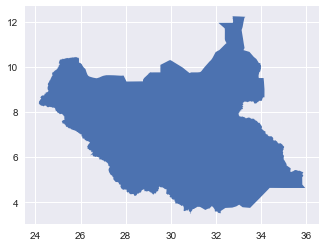

In [602]:
south_sudan_polygon.plot();

In [670]:
south_sudan_grid = gpd.read_file("../data/south_sudan_gridded.geojson")

In [675]:
south_sudan_grid

,id,xmin,xmax,ymin,ymax,admin0Name,admin0Pcod,admin0RefN,admin0AltN,admin0Al_1,date,validOn,validTo,Shape_Leng,Shape_Area,geometry
0,383,32.639881,32.739881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((32.73988089760014 12.23602630628996...
1,384,32.739881,32.839881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((32.83988089760014 12.23254175829666...
2,385,32.839881,32.939881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((32.93988089760014 12.22924969523442...
3,386,32.939881,33.039881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((33.03988089760014 12.22583680677089...
4,387,33.039881,33.139881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((33.13988089760014 12.22051993155772...
5,388,33.139881,33.239881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((33.23988089760014 12.21520305634456...
6,389,33.239881,33.339881,12.155253,12.255253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,"(POLYGON ((33.25623100878622 12.1552533771, 33..."
7,526,32.639881,32.739881,12.055253,12.155253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,(POLYGON ((32.73988089760014 12.15409374863201...
8,527,32.739881,32.839881,12.055253,12.155253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,"(POLYGON ((32.74026742833106 12.1552533771, 32..."
9,528,32.839881,32.939881,12.055253,12.155253,South Sudan,SS,South Sudan,,,2008-12-01,2016-01-14,,51.127946,51.817109,"(POLYGON ((32.83988089760014 12.1552533771, 32..."


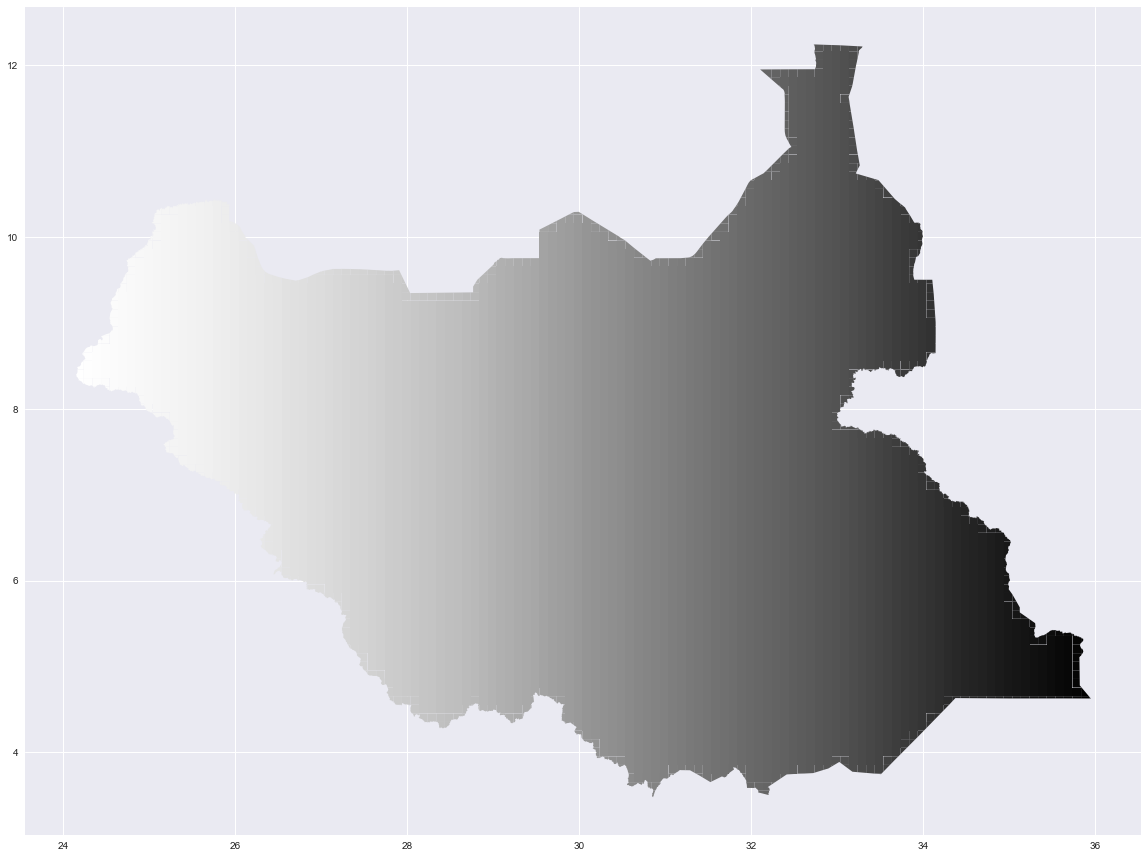

In [677]:
south_sudan_grid.plot(column = 'xmin', figsize=(20,20))

In [504]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='viridis'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    f, ax = plt.subplots(figsize=(10,8))
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    #plt.colorbar()
    plt.gca().invert_yaxis()
    ax.set_axis_off()
    #lims = plt.axis('equal')
    plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


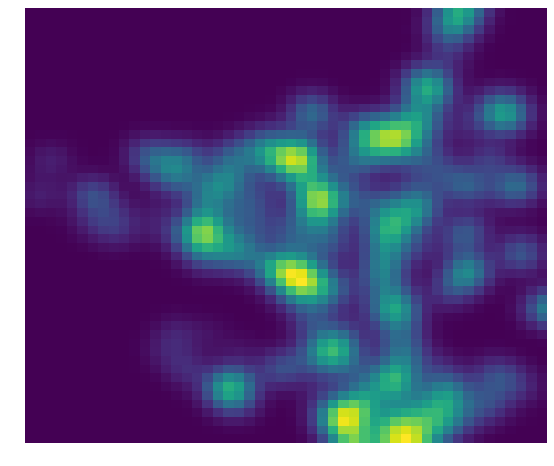

In [505]:
heatmap(south_sudan, bins=50, smoothing=1.5)

Battle-Non-state actor overtakes territory


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


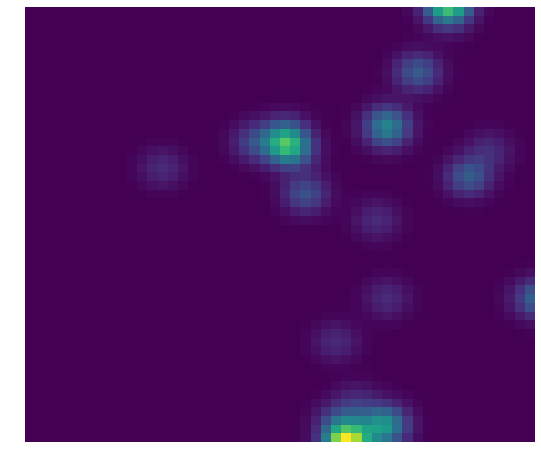

Violence against civilians


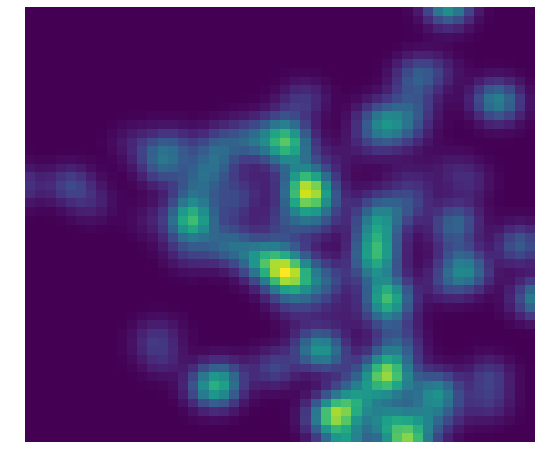

Battle-No change of territory


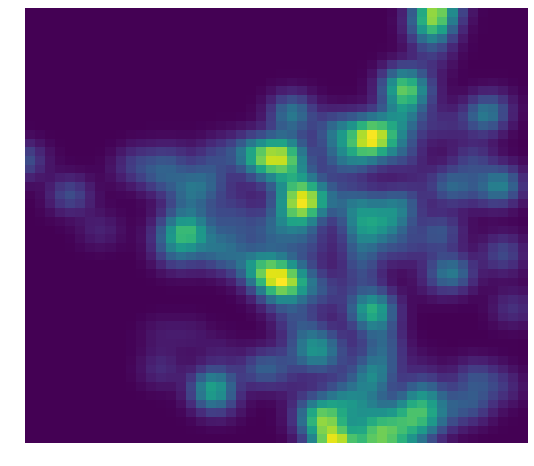

Remote violence


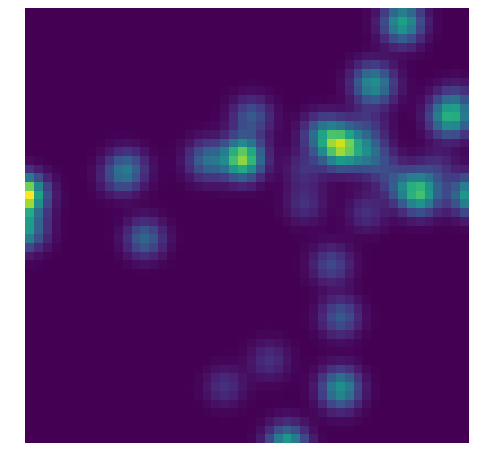

Non-violent transfer of territory


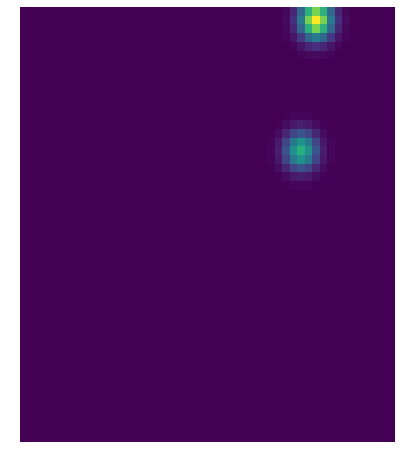

Battle-Government regains territory


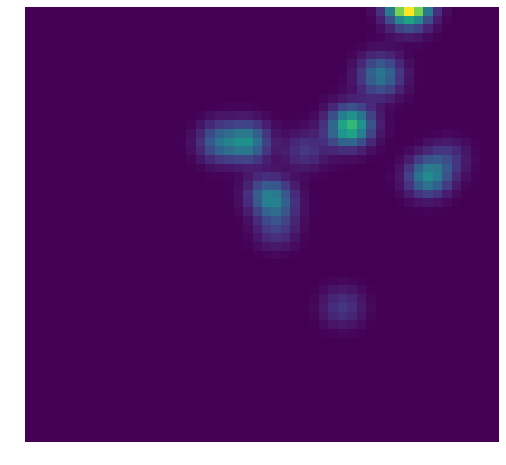

Headquarters or base established


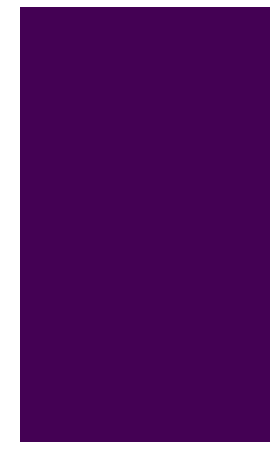

Strategic development


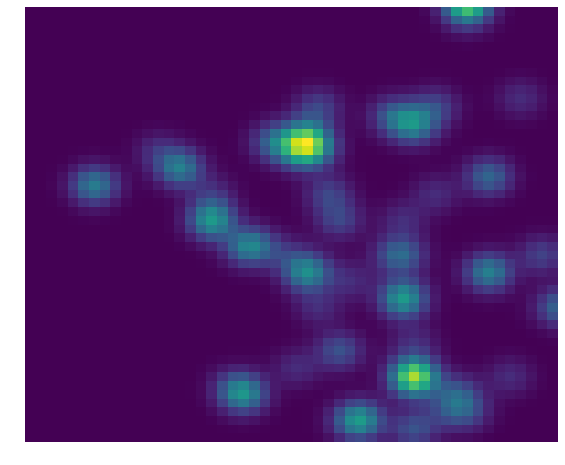

Riots/Protests


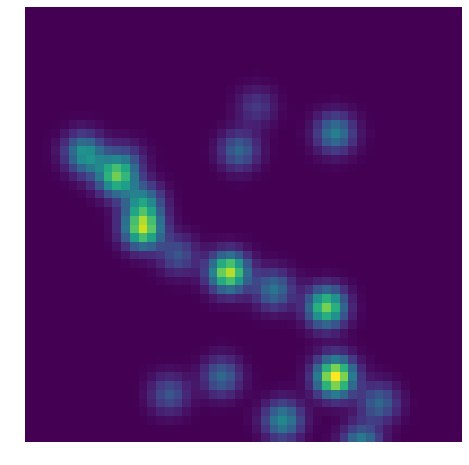

In [506]:
for i in list(set(south_sudan.EVENT_TYPE)):
    print i
    heatmap(south_sudan[south_sudan['EVENT_TYPE'] == i], bins=50, smoothing=1.5)